# An equity cliquet contract


Pre-requisites: Notebook 1.1, 1.2

In this notebook we will create and price an **accumulator clique** and in that process learn to 

- use a **snapper** for contracts with path dependent calculations.
- create a timetable without using `timetable_from_dicts`

Let us start with the imports.

In [ ]:
import numpy as np
import pyarrow as pa
from qablet_contracts.timetable import EVENT_SCHEMA
from qablet.heston.mc import HestonMCModel
from qablet.base.flags import Stats
from matplotlib import pyplot as plt 

## Create the contract

The payoff of an accumulator depends on the returns of an asset over several time periods $T_0 < T_1 < ... T_N$. 

If the returns are given by

$$
r_i = \frac{S_{T_{i+1}}-S_{T_i}}{S_{T_i}}
$$

The contract has a single payoff at $T_N$ is given by

$$
\max \left( 0, \Sigma_0^{N-1} \max(\min(r_i, cap), floor) \right)
$$

To calculate this payoff we will use two path dependent numbers called **snaps**.

 - `S_LAST` to keep track of the last known fixing of the stock
 - `A` to keep track of the accumutated return so far

In [ ]:
# Accumulator Cliquet parameters
global_floor = 0.0
fixings = np.linspace(0, 3, 7)  # T = 3 years, N = 6 fixings
local_floor = -0.03
local_cap = 0.05
ccy = "USD"
asset = "SPX"

The first event is a **snapper** named `INIT` which initializes the **snaps** `S_LAST` and `A`. We will define the `INIT` a little later. A snapper event has no impact on the contract itself.

In [ ]:
events = [
    {
        "track": None,
        "time": fixings[0],
        "op": "s",
        "quantity": 0,
        "unit": "INIT",  # initialize accumulator
    }
]

It is followed by a series of **snapper** events at each fixing time, which updates the accumulator `A` and the last fixing value. 

In [ ]:
for fixing_time in fixings[1:]:
    events.append(
        {
            "track": None,
            "time": fixing_time,
            "op": "s",
            "quantity": 0,
            "unit": "UPDATE",  # update accumulator
        }
    )

Then, at maturity, we apply the global floor, which is an option for the holder of the contract to receive the floor, instead of the accumulator payoff. 

In [ ]:
maturity = fixings[-1]

events.append(
    {
        "track": "",
        "time": maturity,
        "op": ">",  # global floor
        "quantity": global_floor,
        "unit": ccy,
    }
)

Finally, the last event is a payment based on the accumulator. This is expressed by having `A` in the unit column.

In [ ]:
events.append(
    {
        "track": "",
        "time": maturity,
        "op": "+",  # pay the accumulated amount
        "quantity": 1,
        "unit": "A",
    }
)

From this list we can create the events arrow table using the `RecordBatch.from_py_list` method from the `pyarrow` package.

In [ ]:
events_table = pa.RecordBatch.from_pylist(events, schema=EVENT_SCHEMA)
print(events_table.to_pandas())

  track  time op  quantity    unit
0   NaN   0.0  s       0.0    INIT
1   NaN   0.5  s       0.0  UPDATE
2   NaN   1.0  s       0.0  UPDATE
3   NaN   1.5  s       0.0  UPDATE
4   NaN   2.0  s       0.0  UPDATE
5   NaN   2.5  s       0.0  UPDATE
6   NaN   3.0  s       0.0  UPDATE
7         3.0  >       0.0     USD
8         3.0  +       1.0       A


We are not done, because we have not defined `INIT` and `UPDATE` yet. We define a snapper using a dict of four components.

In [ ]:
def accumulator_init_fn(inputs):
    [s] = inputs
    return [0, s]  # [A, S_last]

init = {
    "type": "snapper",
    "inp": [asset],  # what assets should go as inputs to the snapper fn
    "snap_fn": accumulator_init_fn,  # the snapper fn
    "out": ["A", "S_last"],  # what snaps should store the output of the snapper fn
}

Similarly,

In [ ]:
def accumulator_update_fn(inputs):
    [s, s_last, a] = inputs

    ret = s / s_last - 1.0  # ret = S / S_last - 1
    ret = np.maximum(local_floor, ret)
    ret = np.minimum(local_cap, ret)

    return [a + ret, s]  # [A, S_last]

update = {
    "type": "snapper",
    "inp": [asset, "S_last", "A"],   # what assets, or previous snaps should go as inputs to the snapper fn
    "snap_fn": accumulator_update_fn,  # the snapper fn
    "out": ["A", "S_last"],  # what snaps should store the output of the snapper fn
}

Also see [qablet-contracts/specifications/snapper/](https://qablet.github.io/qablet-contracts/specifications/snapper/)
Now we have all components needed to define our timetable.


In [ ]:

timetable = {
    "events": events_table,
    "expressions": {
        "INIT": init,
        "UPDATE": update,
    }
}

## Calculate Price (Heston)

To price this contract, we can use the same `HestonMCModel` from the qablet library that we used to price the vanilla option contract. Recall that this model requires HESTON model parameters to be included in the dataset. However, this part is independent of the contract, so we can use the same dataset that we used for the vanilla option.

In [ ]:


times = np.array([0.0, 1.0, 2.0, 5.0])
rates = np.array([0.04, 0.04, 0.045, 0.05])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

spot = 2900
div_rate = 0.01
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

heston_dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 250,
        "SEED": 1,
    },
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "HESTON": {
        "ASSET": "SPX",
        "INITIAL_VAR": 0.0654,
        "LONG_VAR": 0.0707,
        "VOL_OF_VAR": 0.2928,
        "MEANREV": 0.6067,
        "CORRELATION": -0.7571,
    }
}
model = HestonMCModel()
price, _ = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")

price:    0.082530


## Pricing Stats
As we saw in the vannial option notebok, we can use the `PV_VEC` flag to get the distribution of prices.

In [ ]:
heston_dataset["MC"]["FLAGS"] = Stats.PV_VEC

model = HestonMCModel()
price, stats = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")
print(f"stats: {stats}")

price:    0.082530
stats: {'PV_VEC': array([0.11408917, 0.        , 0.        , ..., 0.19062234, 0.12130513,
       0.19062234])}


We can use this data to get the standard deviation of the simulation.

In [ ]:
pv_vec = stats["PV_VEC"]
print(f"std = {pv_vec.std():.6f}")
print(f"max = {pv_vec.max():.6f}")
print(f"min = {pv_vec.min():.6f}")

std = 0.069498
max = 0.259940
min = 0.000000


We can use this data to plot the probability density.

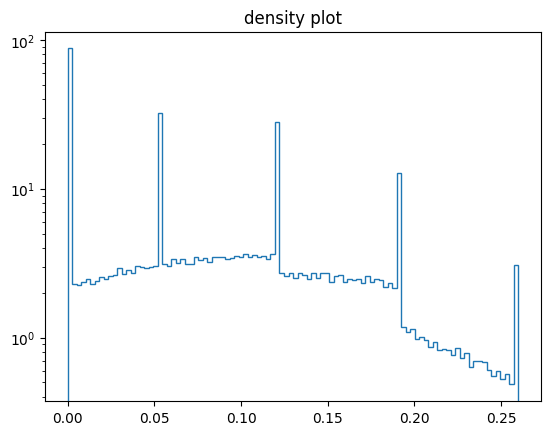

In [ ]:
plt.hist(pv_vec, bins=100, density=True, histtype="step", log=True)
plt.title("density plot") 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6357ff-4a45-421b-9726-87fe96e1ac03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>